<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/hbayes_binom_rats_pymc3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We fit a hierarchical beta-binomial model to some count data derived from rat survival. (In the book, we motivate this in terms of covid incidence rates.)
Based on https://docs.pymc.io/notebooks/GLM-hierarchical-binominal-model.html


In [1]:

import sklearn
import scipy.stats as stats
import scipy.optimize
import matplotlib.pyplot as plt
import seaborn as sns
import time
import numpy as np
import os
import pandas as pd

In [2]:
#!pip install pymc3 # colab uses 3.7 by default (as of April 2021)

 # arviz needs 3.8+
#!pip install pymc3>=3.8 # fails to update
!pip install pymc3==3.11 

import pymc3 as pm
print(pm.__version__)

import arviz as az
print(az.__version__)

     |████████████████████████████████| 870kB 15.2MB/s 
     |████████████████████████████████| 1.6MB 30.9MB/s 
     |████████████████████████████████| 1.8MB 48.7MB/s 
     |████████████████████████████████| 4.7MB 49.6MB/s 
     |████████████████████████████████| 768kB 52.1MB/s 
     |████████████████████████████████| 317kB 53.4MB/s 
  Created wheel for theano-pymc: filename=Theano_PyMC-1.1.0-cp37-none-any.whl size=1530105 sha256=12f4d4f7b8e30531c363d5d43713c1fa6d87dccbf67a5d830a6dbf129feb11ee
  Stored in directory: /root/.cache/pip/wheels/04/f4/99/b28060d0c539d136469541a984e54372a4ce8cd995f9de257f
Successfully built theano-pymc
  Found existing installation: xarray 0.15.1
    Uninstalling xarray-0.15.1:
      Successfully uninstalled xarray-0.15.1
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7
3.11.0
0.11.2


In [3]:



import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
#import seaborn as sns
import pymc3 as pm
import arviz as az
import theano.tensor as tt

In [4]:
np.random.seed(123)




# rat data (BDA3, p. 102)
y = np.array([
    0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,
    1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  1,  5,  2,
    5,  3,  2,  7,  7,  3,  3,  2,  9, 10,  4,  4,  4,  4,  4,  4,  4,
    10,  4,  4,  4,  5, 11, 12,  5,  5,  6,  5,  6,  6,  6,  6, 16, 15,
    15,  9,  4
])
n = np.array([
    20, 20, 20, 20, 20, 20, 20, 19, 19, 19, 19, 18, 18, 17, 20, 20, 20,
    20, 19, 19, 18, 18, 25, 24, 23, 20, 20, 20, 20, 20, 20, 10, 49, 19,
    46, 27, 17, 49, 47, 20, 20, 13, 48, 50, 20, 20, 20, 20, 20, 20, 20,
    48, 19, 19, 19, 22, 46, 49, 20, 20, 23, 19, 22, 20, 20, 20, 52, 46,
    47, 24, 14
])

N = len(n)

In [5]:

def logp_ab(value):
    ''' prior density'''
    return tt.log(tt.pow(tt.sum(value), -5/2))


with pm.Model() as model:
    # Uninformative prior for alpha and beta
    ab = pm.HalfFlat('ab',
                     shape=2,
                     testval=np.asarray([1., 1.]))
    pm.Potential('p(a, b)', logp_ab(ab))
    alpha = pm.Deterministic('alpha', ab[0])
    beta = pm.Deterministic('beta', ab[1])
    X = pm.Deterministic('X', tt.log(ab[0]/ab[1]))
    Z = pm.Deterministic('Z', tt.log(tt.sum(ab)))

    theta = pm.Beta('theta', alpha=ab[0], beta=ab[1], shape=N)

    p = pm.Binomial('y', p=theta, observed=y, n=n)
    #trace = pm.sample(1000, tune=2000, target_accept=0.95)
    trace = pm.sample(1000, tune=500)
    
    
#az.plot_trace(trace)
#plt.savefig('../figures/hbayes_binom_rats_trace.png', dpi=300)

print(az.summary(trace))

/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:468: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  FutureWarning,
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta, ab]


/usr/local/lib/python3.7/dist-packages/pymc3/math.py:246: RuntimeWarning: divide by zero encountered in log1p
  return np.where(x < 0.6931471805599453, np.log(-np.expm1(-x)), np.log1p(-np.exp(-x)))


Sampling 2 chains for 500 tune and 1_000 draw iterations (1_000 + 2_000 draws total) took 13 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.
/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


             mean     sd  hdi_3%  hdi_97%  ...  mcse_sd  ess_bulk  ess_tail  r_hat
ab[0]       2.349  0.793   1.032    3.867  ...    0.034     314.0     258.0    1.0
ab[1]      14.059  4.857   5.816   23.162  ...    0.204     356.0     315.0    1.0
alpha       2.349  0.793   1.032    3.867  ...    0.034     314.0     258.0    1.0
beta       14.059  4.857   5.816   23.162  ...    0.204     356.0     315.0    1.0
X          -1.787  0.110  -2.000   -1.592  ...    0.002    1691.0    1544.0    1.0
...           ...    ...     ...      ...  ...      ...       ...       ...    ...
theta[66]   0.270  0.054   0.167    0.366  ...    0.001    1343.0    1208.0    1.0
theta[67]   0.280  0.059   0.180    0.399  ...    0.001    1763.0     792.0    1.0
theta[68]   0.274  0.056   0.174    0.384  ...    0.001    1807.0     917.0    1.0
theta[69]   0.283  0.075   0.146    0.428  ...    0.001    1427.0     595.0    1.0
theta[70]   0.211  0.077   0.072    0.353  ...    0.001    1971.0     844.0    1.0

[77

post mean
[0.06250048 0.06402225 0.06255513 0.06220665 0.06167195 0.06278546
 0.06296543 0.06466455 0.06495876 0.06492123 0.06458277 0.06799608
 0.06721125 0.06772542 0.09216078 0.09084235 0.09015563 0.09108131
 0.09197539 0.09497408 0.09514938 0.09631936 0.10453873 0.10673986
 0.10926451 0.11942556 0.11866935 0.11773683 0.11902763 0.11815888
 0.11962079 0.12496396 0.11204395 0.12336284 0.11707665 0.12353648
 0.12935247 0.14388365 0.14700019 0.14979858 0.14588528 0.14874647
 0.17849817 0.18685075 0.17599834 0.17612105 0.17485326 0.17428309
 0.17655496 0.17485022 0.1748068  0.1917964  0.18065068 0.1803869
 0.18098781 0.19422429 0.21338237 0.22032463 0.20484105 0.20564112
 0.21352013 0.20809013 0.22109538 0.23192191 0.23289961 0.23154122
 0.27005583 0.28001535 0.27391437 0.28331015 0.21106161]
hyper mean
0.14315873494225628
pooled mle
0.1535365152386429


/usr/local/lib/python3.7/dist-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


Text(0.5, 1.0, 'posterior mean (red line = hparam)')

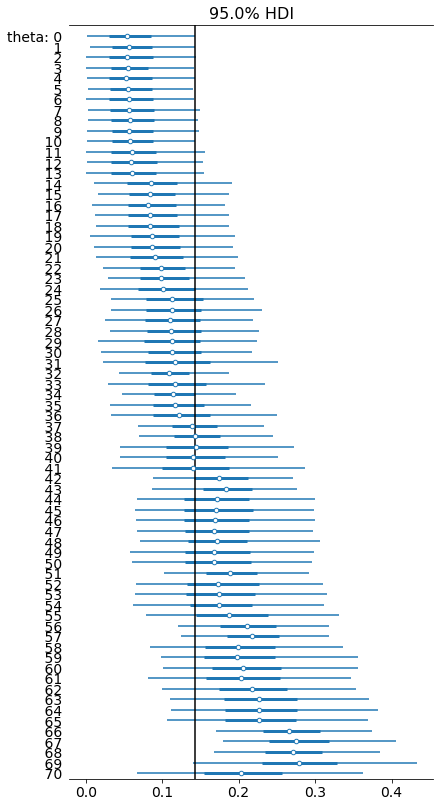

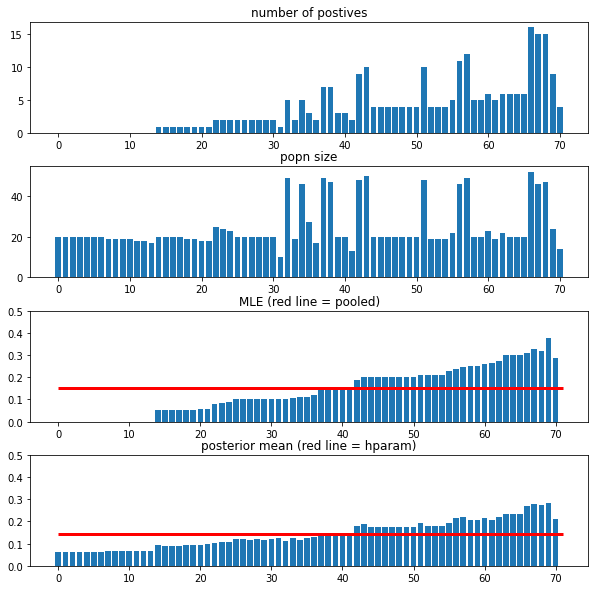

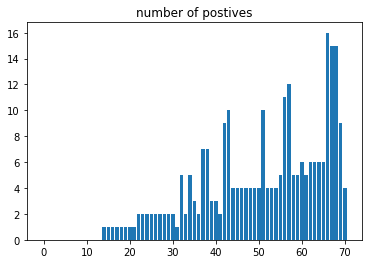

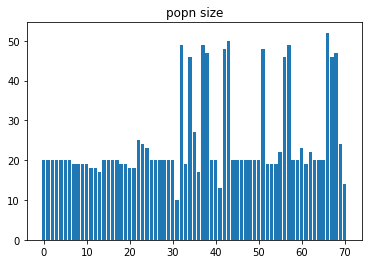

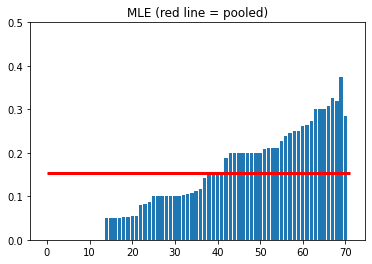

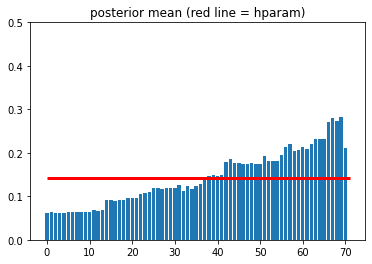

In [7]:

J = len(n)
post_mean = np.zeros(J)
samples = trace[theta]
post_mean = np.mean(samples, axis=0)
print('post mean')
print(post_mean)

alphas = trace['alpha']
betas = trace['beta']
alpha_mean = np.mean(alphas)
beta_mean = np.mean(betas)
hyper_mean = alpha_mean/(alpha_mean + beta_mean)
print('hyper mean')
print(hyper_mean)


mle = y / n
pooled_mle = np.sum(y) / np.sum(n)

print('pooled mle')
print(pooled_mle)


#axes = az.plot_forest(
#    trace, var_names='theta', credible_interval=0.95, combined=True, colors='cycle')

axes = az.plot_forest(
    trace, var_names='theta', hdi_prob=0.95, combined=True, colors='cycle')

y_lims = axes[0].get_ylim()
axes[0].vlines(hyper_mean, *y_lims)
#plt.savefig('../figures/hbayes_binom_rats_forest95.pdf', dpi=300)


J = len(n)
fig, axs = plt.subplots(4,1, figsize=(10,10))
plt.subplots_adjust(hspace=0.3)
axs = np.reshape(axs, 4)
xs = np.arange(J)
ax = axs[0]
ax.bar(xs, y)
ax.set_title('number of postives')
ax = axs[1]
ax.bar(xs, n)
ax.set_title('popn size')
ax = axs[2]
ax.bar(xs, mle)
ax.set_ylim(0, 0.5)
ax.hlines(pooled_mle, 0, J, 'r', lw=3)
ax.set_title('MLE (red line = pooled)')
ax = axs[3]
ax.bar(xs, post_mean)
ax.hlines(hyper_mean, 0, J, 'r', lw=3)
ax.set_ylim(0, 0.5)
ax.set_title('posterior mean (red line = hparam)')
#plt.savefig('../figures/hbayes_binom_rats_barplot.pdf', dpi=300)


J = len(n)
xs = np.arange(J)
fig, ax = plt.subplots(1,1)
ax.bar(xs, y)
ax.set_title('number of postives')
#plt.savefig('../figures/hbayes_binom_rats_outcomes.pdf', dpi=300)

fig, ax = plt.subplots(1,1)
ax.bar(xs, n)
ax.set_title('popn size')
#plt.savefig('../figures/hbayes_binom_rats_popsize.pdf', dpi=300)

fig, ax = plt.subplots(1,1)
ax.bar(xs, mle)
ax.set_ylim(0, 0.5)
ax.hlines(pooled_mle, 0, J, 'r', lw=3)
ax.set_title('MLE (red line = pooled)')
#plt.savefig('../figures/hbayes_binom_rats_MLE.pdf', dpi=300)

fig, ax = plt.subplots(1,1)
ax.bar(xs, post_mean)
ax.hlines(hyper_mean, 0, J, 'r', lw=3)
ax.set_ylim(0, 0.5)
ax.set_title('posterior mean (red line = hparam)')
#plt.savefig('../figures/hbayes_binom_rats_postmean.pdf', dpi=300)
